# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

 **Выбор локации для нефтяной скважины** 
 
В нашем распоряжении данные о пробах нефти в трех регионах. В каждом регионе имеется 10000 месторождений с измеренными показателями качетсва нефти и объемов запасов. Основная задача проекта заключается в определении региона, где добыча нефти приненсет максимальную прибыль.

 **Цель исследования**
 
Цель проекта заключается в анализе данных о месторождениях нефти, а именно:
1. Проанализировать основную информацию о трех регионах.
2. Подготовить математическую модель.
3. Провести расчет прибыли и рисков.


**Ход исследования**

Данные для исследования получены из трех датафреймов. В основных данных есть информация о идентификационном номере скважины, запасе нефти и влияющих на него признаках. О качестве данных ничего не известно, поэтому понадобится их обзор.

Данные будут проверены на ошибки. На этапе предобработки будет рассмотрена возможность устранения ошибок, при их наличии. 

Таким образом, исследование будет состоять из следующих этапов:
- обзор данных;
- предобработка данных;
- обучение и проверка модели;
- подготовка к расчету прибыли;
- написание функции для расчёта прибыли по выбранным скважинам и предсказаниям модели;
- расчёт прибыли и рисков с применением техники Bootstrap;
- основные выводы.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from scipy import stats as st
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder 

from numpy.random import RandomState
RANDOM_STATE = RandomState(42)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)

pd.set_option("precision", 2)

Проведем загрузку датафреймов.

In [2]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

Выведем основную информацию о данных.

In [3]:
data_list = [data_0,data_1,data_2]
for data in data_list:
    display(data.head(2))
    print(data.info()) 

,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,kBEdx,-15.00,-8.28,-5.88e-03,3.18
1,62mP7,14.27,-3.48,9.99e-01,26.95


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,fwXo0,-1.15,0.96,-0.83,27.76
1,WJtFt,0.26,0.27,-2.53,56.07


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


Проверим данные на пропуски.

In [4]:
for data in data_list:
        print(data.isna().sum())

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


Пропуски в данных отсутствуют.

Проверим данные на дубликаты.

In [5]:
data_0.duplicated().sum(), data_1.duplicated().sum(), data_2.duplicated().sum()

(0, 0, 0)

In [6]:
for data in data_list:
    print(data['id'].duplicated().value_counts())  
    duplicates = data[data['id'].duplicated()].id.tolist()
    display(data[data['id'].isin(duplicates)].sort_values(by = 'id'))

False    99990
True        10
Name: id, dtype: int64


,id,f0,f1,f2,product
66136,74z30,1.08,-3.12e-01,6.99,127.64
64022,74z30,0.74,4.59e-01,5.15,140.77
51970,A5aEY,-0.18,9.36e-01,-2.09,33.02
3389,A5aEY,-0.04,1.57e-01,0.21,89.25
69163,AGS9W,-0.93,1.16e-01,-3.66,19.23
42529,AGS9W,1.45,-4.80e-01,0.68,126.37
931,HZww2,0.76,3.69e-01,1.86,30.68
7530,HZww2,1.06,-3.74e-01,10.43,158.83
63593,QcMuo,0.64,-4.73e-01,0.86,64.58
1949,QcMuo,0.51,-3.24e-01,-2.22,75.50


False    99996
True         4
Name: id, dtype: int64


,id,f0,f1,f2,product
5849,5ltQ6,-3.44,-12.30,2.00e+00,57.09
84461,5ltQ6,18.21,2.19,3.99e+00,107.81
1305,LHZR0,11.17,-1.95,3.00e+00,80.86
41906,LHZR0,-8.99,-4.29,2.01e+00,57.09
2721,bfPNe,-9.49,-5.46,4.01e+00,110.99
82178,bfPNe,-6.20,-4.82,3.00e+00,84.04
47591,wt4Uk,-9.09,-8.11,-2.31e-03,3.18
82873,wt4Uk,10.26,-9.38,4.99e+00,134.77


False    99996
True         4
Name: id, dtype: int64


,id,f0,f1,f2,product
45404,KUPhW,0.23,-1.70,4.99,11.72
55967,KUPhW,1.21,3.18,5.54,132.83
11449,VF7Jo,2.12,-0.86,5.75,181.72
49564,VF7Jo,-0.88,0.56,0.72,136.23
44378,Vcm5J,-1.23,-2.44,1.22,137.97
95090,Vcm5J,2.59,1.99,2.48,92.33
28039,xCHr8,1.63,0.37,-2.38,6.12
43233,xCHr8,-0.85,2.10,5.60,184.39


В показателях ID имеются дубликаты, при этом основные показатели и целевой показатель разные, поэтому оставим эти данные. Удалим столбец с ID так как для модели он не нужен.

In [7]:
for data in data_list:
    data.drop(columns=['id'],axis=1, inplace=True)
    display(data.tail(3))

,f0,f1,f2,product
99997,1.03,0.02,-1.35,64.38
99998,1.00,-0.53,1.58,74.04
99999,1.76,-0.27,5.72,149.63


,f0,f1,f2,product
99997,-7.38,-3.08,5.00e+00,137.95
99998,0.67,-6.15,1.00e+00,30.13
99999,-3.43,-7.79,-3.30e-03,3.18


,f0,f1,f2,product
99997,-1.20,-2.96,5.22,157.08
99998,-2.42,2.42,-5.55,51.80
99999,-2.55,-2.03,6.09,102.78


Посмотрим основные показатели датафреймов.

In [8]:
for data in data_list:
    print(data.describe())

              f0         f1         f2    product
count  100000.00  100000.00  100000.00  100000.00
mean        0.50       0.25       2.50      92.50
std         0.87       0.50       3.25      44.29
min        -1.41      -0.85     -12.09       0.00
25%        -0.07      -0.20       0.29      56.50
50%         0.50       0.25       2.52      91.85
75%         1.07       0.70       4.72     128.56
max         2.36       1.34      16.00     185.36
              f0         f1         f2    product
count  100000.00  100000.00  100000.00  100000.00
mean        1.14      -4.80       2.49      68.83
std         8.97       5.12       1.70      45.94
min       -31.61     -26.36      -0.02       0.00
25%        -6.30      -8.27       1.00      26.95
50%         1.15      -4.81       2.01      57.09
75%         8.62      -1.33       4.00     107.81
max        29.42      18.73       5.02     137.95
             f0        f1         f2    product
count  1.00e+05  1.00e+05  100000.00  100000.00
mean

Рассмотрим распределение значений признаков.


Распределение признаков:


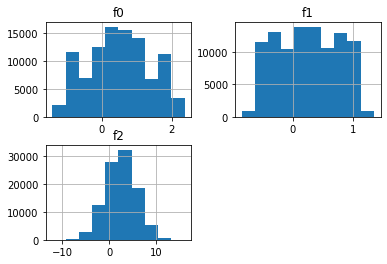


Распределение признаков:


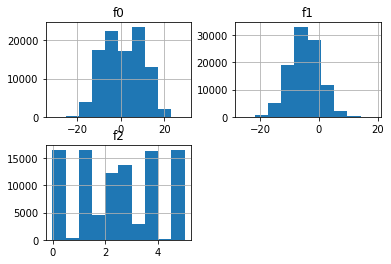


Распределение признаков:


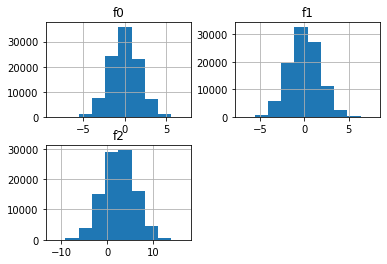

In [9]:
for data in data_list:   
    print("\nРаспределение признаков:")
    data[["f0","f1","f2"]].hist()
    plt.show()

In [51]:
def corr_matrix(data):    
    corr_matrix = data.corr()
    display(corr_matrix)
    fig, ax = plt.subplots(figsize=(15, 6))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm");
    plt.show()

,f0,f1,f2,product
f0,1.00e+00,-4.41e-01,-3.15e-03,0.14
f1,-4.41e-01,1.00e+00,1.72e-03,-0.19
f2,-3.15e-03,1.72e-03,1.00e+00,0.48
product,1.44e-01,-1.92e-01,4.84e-01,1.00


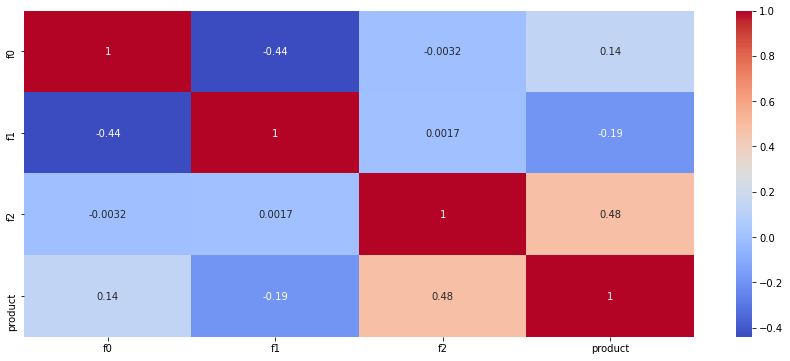

In [52]:
corr_matrix(data_0)

,f0,f1,f2,product
f0,1.00e+00,1.82e-01,-1.78e-03,-0.03
f1,1.82e-01,1.00e+00,-2.60e-03,-0.01
f2,-1.78e-03,-2.60e-03,1.00e+00,1.00
product,-3.05e-02,-1.02e-02,9.99e-01,1.00


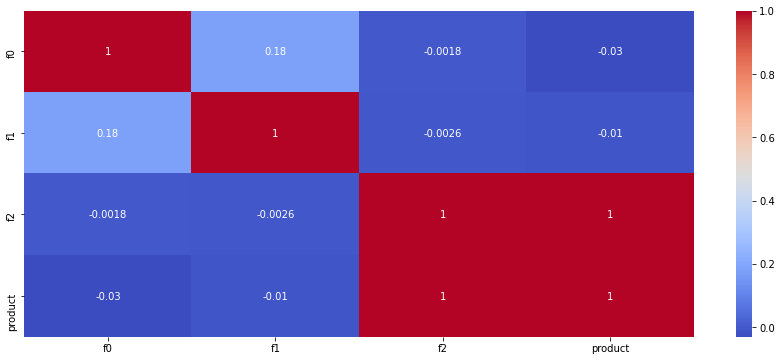

In [53]:
corr_matrix(data_1)

,f0,f1,f2,product
f0,1.00e+00,5.28e-04,-4.48e-04,-1.99e-03
f1,5.28e-04,1.00e+00,7.79e-04,-1.01e-03
f2,-4.48e-04,7.79e-04,1.00e+00,4.46e-01
product,-1.99e-03,-1.01e-03,4.46e-01,1.00e+00


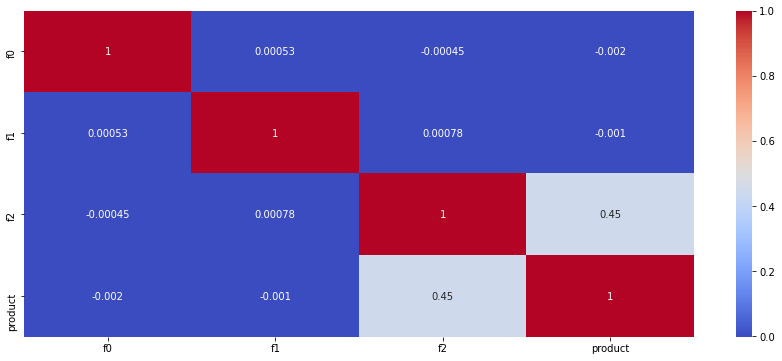

In [54]:
corr_matrix(data_2)

Данные загружены и не требуют дополнительной предобработки. В данных отсутствуют пропуски. В данных обнаружены дубликаты в наименовании ID, но при этом все показатели отличаются, поэтому столбец с ID был удален, так как не влияет на составление модели. Исходя из графиков можно оценить отсутствие больших выбросов в данных. Можно переходить  к процедуре получения модели.

## Обучение и проверка модели

### Деление данных на обучающую и валидационную выборки в соотношении 75:25.

In [11]:
def split_data(data):
    features = data.drop(['product'],axis=1)  # извлеките признаки
    target = data['product']

    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=42)
    
    #сбросим индексы у новых таблиц
    for df in features_train, features_valid, target_train, target_valid:
        df.reset_index(drop=True,inplace =True)
    print(features_train.shape, features_valid.shape, target_train.shape, target_valid.shape)
    return features_train, features_valid, target_train, target_valid

In [12]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = split_data(data_0)
features_train_1, features_valid_1, target_train_1, target_valid_1 = split_data(data_1)
features_train_2, features_valid_2, target_train_2, target_valid_2 = split_data(data_2)

(75000, 3) (25000, 3) (75000,) (25000,)
(75000, 3) (25000, 3) (75000,) (25000,)
(75000, 3) (25000, 3) (75000,) (25000,)


### Обучение модели

In [13]:
def line_model(data, features_train, features_valid, target_train, target_valid):
    # зададим целевой признак и подготовим данные
    target = data['product']
    features = data.drop(['product'], axis=1)
    
       
    # инициируем модели линейной регрессии
    model = LinearRegression()
    # обучим модель
    model.fit(features_train, target_train)
    # сделаем прогнозы
    predicted_valid = model.predict(features_valid)
    
    # посчитаем mse
    mse = mean_squared_error(target_valid, predicted_valid)
    
    # посчитаем rmse
    rmse = mean_squared_error(target_valid, predicted_valid)**0.5
    
    # посчитаем mae
    mae = mean_absolute_error(target_valid, predicted_valid)
    
    # посчитаем средний запас сырья
    predicted_valid_mean = predicted_valid.sum()/len(predicted_valid)
    
    return target_valid, predicted_valid, mse, rmse, mae, predicted_valid_mean


### Получение основных показателей для каждого региона

In [14]:
target_valid_0, predicted_valid_0, mse_0, rmse_0, mae_0, predicted_valid_mean_0 = line_model(data_0, features_train_0, features_valid_0, target_train_0, target_valid_0)
target_valid_1, predicted_valid_1, mse_1, rmse_1, mae_1, predicted_valid_mean_1 = line_model(data_1, features_train_1, features_valid_1, target_train_1, target_valid_1)
target_valid_2, predicted_valid_2, mse_2, rmse_2, mae_2, predicted_valid_mean_2 = line_model(data_2, features_train_2, features_valid_2, target_train_2, target_valid_2)


### Вывод основных показателей и их анализ

In [15]:
print('Регион_0. Средний запас сырья:', predicted_valid_mean_0, 'mse:', mse_0,  'rmse:', rmse_0, 'mae:', mae_0, )
print('Регион_1. Средний запас сырья:', predicted_valid_mean_1, 'mse:', mse_1,  'rmse:', rmse_1, 'mae:', mae_1, )
print('Регион_2. Средний запас сырья:', predicted_valid_mean_2, 'mse:', mse_2,  'rmse:', rmse_2, 'mae:', mae_2, )

Регион_0. Средний запас сырья: 92.39879990657768 mse: 1425.5608700093812 rmse: 37.75660035026169 mae: 31.047681538788183
Регион_1. Средний запас сырья: 68.71287803913762 mse: 0.7925986566392013 rmse: 0.890280100102884 mae: 0.7170119535682554
Регион_2. Средний запас сырья: 94.77102387765939 mse: 1611.6910636385903 rmse: 40.145872311342174 mae: 32.896958610578054


In [16]:
comparison_tabl = pd.DataFrame(index=['средний запас предсказанного сырья','RMSE модели', 'MAE модели'], columns=['регион_0','регион_1','регион_2'])
comparison_tabl['регион_0'] = predicted_valid_0.mean(), rmse_0, mae_0
comparison_tabl['регион_1'] = predicted_valid_1.mean(), rmse_1, mae_1
comparison_tabl['регион_2'] = predicted_valid_2.mean(), rmse_2, mae_2
comparison_tabl

,регион_0,регион_1,регион_2
средний запас предсказанного сырья,92.40,68.71,94.77
RMSE модели,37.76,0.89,40.15
MAE модели,31.05,0.72,32.90


Модели обучены и проверены на качество предсказания метриками RMSE, которая определяет величину среднеквадратичной ошибки в предсказании модели, а также MAE, показывающей среднее абсолютное отклонение модели. Исходя из полученных данных в нашей сводной таблицы, можно заметить, что величины RMSE и MAE в регионе_1 сильно отличается от двух других, это может быть связано с тем, что модель обучилась на практически равных по величине данных, и величина ошибки этой модели не может сильно варьирываться. Также надо учитывать, что модели для региона_0 и региона_2 модели имеют ошибку в 30 тыс. баррелей.

## Подготовка к расчёту прибыли

При разведке региона исследуюем 500 точек, из которых с помощью машинного обучения выберем 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс.
рублей, поскольку объём указан в тысячах баррелей.
После оценки рисков оставим лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выберем регион с наибольшей средней прибылью.

In [55]:
# Все ключевые значения для расчётов сохраним в отдельных переменных.
BUDGET_RUB = 10*10**9 # Бюджет на разработку 200 скважин в регионе
TOTAL_POINTS = 500 # При разведке региона исследуют 500 точек
SELECTED_POINTS = 200 # с помощью машинного обучения выбирают 200 точек лучших для разработки
BUDGET_POINTS_RUB = BUDGET_RUB / SELECTED_POINTS
BARREL_INCOME_RUB = 450 # доход с каждого барреля
UNIT_INCOME_RUB = 450 * 10**3 # доход с каждой единицы продукта
LOSS_THRESHOLD = 2,5 # порог вероятности убытков, максимальное допустимое значение

### Определение точки безубыточности

In [59]:
n = BUDGET_RUB / UNIT_INCOME_RUB
print("Точка безубыточности: {0:.0f} тыс. баррелей".format(n))

Точка безубыточности: 22222 тыс. баррелей


### Определение достаточного объёма сырья для безубыточной разработки новой скважины

In [60]:
breakeven_point = BUDGET_RUB / UNIT_INCOME_RUB / SELECTED_POINTS
print('Объём каждой скважины для безубыточной разработки должен составлять не менее: %.2f'%breakeven_point,'тыс.баррелей')

Объём каждой скважины для безубыточной разработки должен составлять не менее: 111.11 тыс.баррелей


Hасчет порога безубыточности показал, что для скважины он составляет 111 тыс. баррелей, для региона 22 222 тыс. баррелей

### Расчет средней прибыли региона

In [61]:
print('Средняя расчетная прибыль региона_0',\
      SELECTED_POINTS *\
      predicted_valid_mean_0 *\
     UNIT_INCOME_RUB\
     - BUDGET_RUB)
print('Средняя расчетная прибыль региона_1',\
      SELECTED_POINTS *\
      predicted_valid_mean_1 *\
     UNIT_INCOME_RUB\
     - BUDGET_RUB)
print('Средняя расчетная прибыль региона_2',\
      SELECTED_POINTS *\
      predicted_valid_mean_2 *\
     UNIT_INCOME_RUB\
     - BUDGET_RUB)

Средняя расчетная прибыль региона_0 -1684108008.4080086
Средняя расчетная прибыль региона_1 -3815840976.4776144
Средняя расчетная прибыль региона_2 -1470607851.0106544


### Определение среднего запаса сырья в регионе

In [62]:
names = ['Регион_0', 'Регион_1', 'Регион_2']

In [63]:
for name, data in zip(names, data_list):
    print()
    print(f'Средний запас в {name} регионе = {data["product"].mean():.2f} тыс. баррелей.')
    print(f'Процент скважин с объёмом больше чем порог = {len(data.query("product > @breakeven_point")) / len(data):.2%}')



Средний запас в Регион_0 регионе = 92.50 тыс. баррелей.
Процент скважин с объёмом больше чем порог = 36.58%

Средний запас в Регион_1 регионе = 68.83 тыс. баррелей.
Процент скважин с объёмом больше чем порог = 16.54%

Средний запас в Регион_2 регионе = 95.00 тыс. баррелей.
Процент скважин с объёмом больше чем порог = 38.18%


### Сравнение полученного объёма сырья со средним запасом в каждом регионе

In [64]:
# отклонение от среднего в регионе_0
distraction_0 = predicted_valid_mean_0 - breakeven_point

In [65]:
print(f'Разница объёма сырья для безубыточной разработки скважины относительно среднего значения по региону_0 составляет:  \
{round(distraction_0, 2)} тыс. баррелей')

Разница объёма сырья для безубыточной разработки скважины относительно среднего значения по региону_0 составляет:  -18.71 тыс. баррелей


In [66]:
# отклонение от среднего в регионе_1
distraction_1 = predicted_valid_mean_1 - breakeven_point

In [67]:
print(f'Разница объёма сырья для безубыточной разработки скважины относительно среднего значения по региону_1 составляет:  \
{round(distraction_1, 2)} тыс. баррелей')

Разница объёма сырья для безубыточной разработки скважины относительно среднего значения по региону_1 составляет:  -42.4 тыс. баррелей


In [68]:
# отклонение от среднего в регионе_2
distraction_2 = predicted_valid_mean_2 - breakeven_point

In [69]:
print(f'Разница объёма сырья для безубыточной разработки скважины относительно среднего значения по региону_2 составляет:  \
{round(distraction_2, 2)} тыс. баррелей')

Разница объёма сырья для безубыточной разработки скважины относительно среднего значения по региону_2 составляет:  -16.34 тыс. баррелей


Определен достаточный объём сырья для безубыточной разработки новой скважины, равный 111,11 тыс. баррелей. В каждом из трёх регионов средний запас сырья скважины меньше полученного значения достаточного объёма сырья на 18.7, 42.4, 16.3 тыс. баррелей. На основании данного заключения можно отметить высокий риск разработок скважин преимущественно в регионе_1. Средний запас в регионах варьируется от 68 до 95 тыс. баррелей. Исходя из полученных данных становится очевидно, что среднее количество запасов сырья по регионам недостаточное даже для окупаемости разработки, требуется выбрать скважины с максимальными запасами.

 ## Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели

### Выбор скважин с максимальными значениями предсказаний.

In [70]:
predicted_valid_0

array([101.90101715,  78.21777385, 115.26690103, ...,  82.54439653,
        81.82668931,  93.12106221])

Привязка индексов скважин к предсказаниям модели и сортировка списка по убыванию

In [71]:
probs_sorted_0 = pd.Series(predicted_valid_0, index=target_valid_0.index).sort_values(ascending=False)
selected_max_0 = probs_sorted_0[:200]
selected_max_0

6958     176.54
18194    176.27
17251    173.25
457      172.80
2202     172.74
          ...  
8772     146.95
15975    146.95
7846     146.95
6633     146.95
7154     146.87
Length: 200, dtype: float64

### Суммирование целевого значения объёма сырья и расчет совокупной прибыли

In [72]:
selected_max_0_sum = selected_max_0.sum()
print('Суммарный запас сырья в 200 лучших скважинах составит: %.2f тыс.баррелей'%selected_max_0_sum)

Суммарный запас сырья в 200 лучших скважинах составит: 30881.46 тыс.баррелей


In [73]:
profit_pred_0=(selected_max_0_sum*UNIT_INCOME_RUB) - BUDGET_RUB
print('Прибыль для полученного объёма сырья составит %.2f тыс.рублей'%profit_pred_0)

Прибыль для полученного объёма сырья составит 3896658479.67 тыс.рублей


### Автоматизирование процедур вычисления в функции

In [76]:
def profit_for_vp(predict,target,count):
    probs_sorted = pd.Series(predict, index=target.index).sort_values(ascending=False)
    selected_max = probs_sorted[:count].sum()
    profit_pred=(selected_max*UNIT_INCOME_RUB)-BUDGET_RUB
    print('Суммарный запас сырья в 200 лучших скважинах составит: %.2f тыс.баррелей'%selected_max)
    print('Прибыль для полученного объёма сырья составит %.2f млн.рублей'%(profit_pred/1000000))


Прибыль для региона_0

In [77]:
profit_for_vp(predicted_valid_0,target_valid_0,200)

Суммарный запас сырья в 200 лучших скважинах составит: 30881.46 тыс.баррелей
Прибыль для полученного объёма сырья составит 3896.66 млн.рублей


Прибыль для региона_1

In [78]:
profit_for_vp(predicted_valid_1,target_valid_1,200)

Суммарный запас сырья в 200 лучших скважинах составит: 27748.75 тыс.баррелей
Прибыль для полученного объёма сырья составит 2486.94 млн.рублей


Прибыль для региона_2

In [79]:
profit_for_vp(predicted_valid_2,target_valid_2,200)

Суммарный запас сырья в 200 лучших скважинах составит: 29728.85 тыс.баррелей
Прибыль для полученного объёма сырья составит 3377.98 млн.рублей


Проведенный расчет суммарного запаса сырья в 200 лучших скважинах и прибыли для полученного объема показал, что все три региона потенциально прибыльные, для определения наиболее выгодного с точки зрения окупаемости вложений и рисков убытка далее проведём расчёт вероятности.

## Расчёт прибыли и рисков 

### Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли

Найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков

При́быль
- положительная разница между суммарными доходами (выручка от реализации товаров и услуг) и затратами на разработку скважин

Убыток
- уменьшение материальных и денежных ресурсов в результате превышения расходов над доходами (отрицательная прибыль)

In [37]:
def profit_for_vp2(predict,target,count):
    probs_sorted = pd.Series(predict).sort_values(ascending=False)
    selected_points = target[probs_sorted.index][:count]
    product = selected_points.sum()
    revenue = product * unit_income_rub 
    return revenue - budget_rub

In [98]:
def bootstap_1000(target,predict):
    values = []
    count=0
    state = np.random.RandomState(42)
    predict_e = pd.Series(predict, index=target.index)
    
    for i in tqdm(range(1000)):
        target_subsample = target.sample(n=500,replace=True, random_state=state)
  
        probs_subsample = predict_e[target_subsample.index]
        values.append(profit_for_vp2(probs_subsample,target_subsample, 200))  
    
   
            
    values = pd.Series(values)
    mean = values.mean()
    risk = (values < 0).mean()

    
    plt.title('Распределение прибыли')
    values.plot(kind="hist", grid=True, figsize=(8,5))
    plt.xlabel('Прибыль, тыс.руб')
    plt.ylabel('Количество')
    plt.show()
    
    low_95 = values.quantile(0.025)
    high_95 = values.quantile(0.975)
    
    print("Средняя прибыль: {:.2f} млн.руб".format(mean/1000000))
    print('С вероятностью 95% прибыль в данном регионе будет составлять от: {:.2f} млн.руб до: {:.2f} млн.руб'.format((low_95/1000000),(high_95/1000000)))
    print ('Процент вероятности убытка в данном регионе составит {:.1%}'.format(risk))

Распределение прибыли регион_0

  0%|          | 0/1000 [00:00<?, ?it/s]

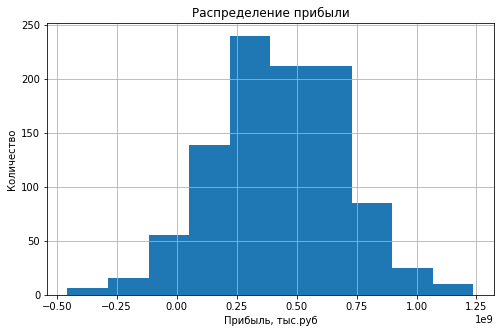

Средняя прибыль: 427.85 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять от: -97.25 млн.руб до: 954.22 млн.руб
Процент вероятности убытка в данном регионе составит 5.5%


In [99]:
bootstap_1000(target_valid_0,predicted_valid_0)

Распределение прибыли регион_1

  0%|          | 0/1000 [00:00<?, ?it/s]

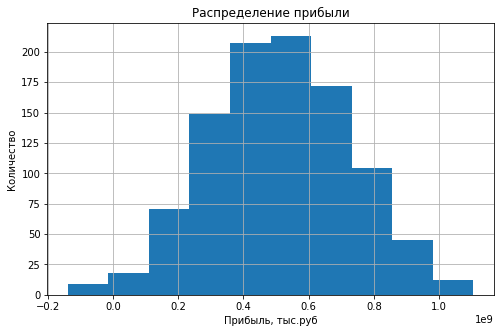

Средняя прибыль: 511.36 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять от: 98.87 млн.руб до: 940.72 млн.руб
Процент вероятности убытка в данном регионе составит 0.9%


In [100]:
bootstap_1000(target_valid_1,predicted_valid_1)

Распределение прибыли регион_2

  0%|          | 0/1000 [00:00<?, ?it/s]

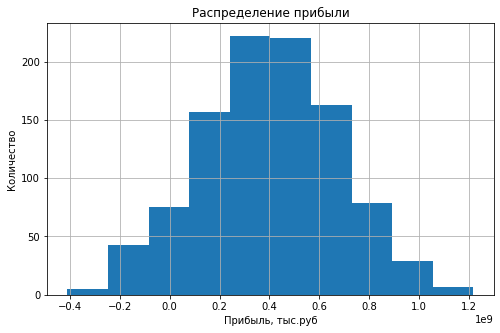

Средняя прибыль: 402.58 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять от: -137.16 млн.руб до: 929.89 млн.руб
Процент вероятности убытка в данном регионе составит 7.4%


In [101]:
bootstap_1000(target_valid_2,predicted_valid_2)

### Выбор региона

После оценки рисков оставим лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выберем регион с наибольшей средней прибылью

In [42]:
comparison_tabl = pd.DataFrame(index=['Средняя прибыль в регионе, млн.руб','Суммарный запас сырья, тыс.баррелей','Вероятность убытка, %'], 
                               columns=['регион_0','регион_1','регион_2'])
comparison_tabl['регион_0'] = '427.35', '30881.96','5.5'
comparison_tabl['регион_1'] = '511.36', '27748.75','0.9'
comparison_tabl['регион_2'] = '402.58', '29730.68','7.4'
comparison_tabl

,регион_0,регион_1,регион_2
"Средняя прибыль в регионе, млн.руб",427.35,511.36,402.58
"Суммарный запас сырья, тыс.баррелей",30881.96,27748.75,29730.68
"Вероятность убытка, %",5.5,0.9,7.4


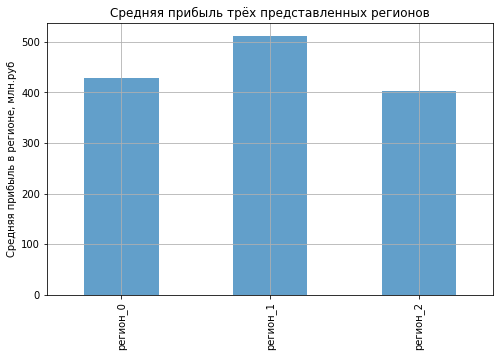

In [43]:
comparison_tabl.astype('float').iloc[0,:].plot(kind="bar", figsize=(8,5), grid=True, alpha=0.7, subplots=True)
plt.title('Средняя прибыль трёх представленных регионов')
plt.ylabel('Средняя прибыль в регионе, млн.руб')
plt.show()

Согласно распределению среднего значения прибыли с региона, самым прибыльным оказался регион_1, средняя прибыль в этом регионе составит 511,36 млн.рублей. Два других региона не прошли отбор по минимально допустимому порогу убытка в 2,5%. Таким образом не смотря на сравнительно меньшие запасы сырья, по сравнению с другими регионами, средняя доходность со скважин во регионе_1 прогнозируется выше других.

## Основные выводы

Рассмотрены данные по запасам в скважинах трёх регионов, в каждом из которых представлены сведения о запасах нефти по 10 тыс.скважинам. имеются обезличенные признаки, влияющие на запасы в скважинах.Основная задача проекта заключалась в определении региона, где добыча нефти приненсет максимальную прибыль.  

Данные были загружены и не потребовали дополнительной предобработки. В данных отсутствуют пропуски. В данных обнаружены дубликаты в наименовании ID, но при этом все показатели отличаются, поэтому столбец с ID был удален, так как не влияет на составление модели. Исходя из графиков было выявлено отсутствие больших выбросов в данных. 

Для оценки перспективы разработки по регионам, была обучена модель и выполнены предсказания среднего запаса сырья по регионам при помощи линейной регрессии. Модели были проверены на качество предсказания метриками RMSE, которая определяет величину среднеквадратичной ошибки в предсказании модели, а также MAE, показывающей среднее абсолютное отклонение модели. Исходя из полученных данных вустановлено, что величины RMSE и MAE в регионе_1 сильно отличается от двух других, модель обладает лучшими показателями. Также надо учитывать, что модели для региона_0 и региона_2 модели имеют ошибку в 30 тыс. баррелей, что достаточно существенно.

Определен достаточный объём сырья для безубыточной разработки новой скважины, равный 111,11 тыс. баррелей. В каждом из трёх регионов средний запас сырья скважины меньше полученного значения достаточного объёма сырья на 18.7, 42.4, 16.3 тыс. баррелей. На основании данного заключения можно отметить высокий риск разработок скважин преимущественно в регионе_1. Средний запас в регионах варьируется от 68 до 95 тыс. баррелей. Исходя из полученных данных становится очевидно, что среднее количество запасов сырья по регионам недостаточное даже для окупаемости разработки, требуется выбрать скважины с максимальными запасами.

Проведенный расчет суммарного запаса сырья в 200 лучших скважинах и прибыли для полученного объема показал, что все три региона потенциально прибыльные, для определения наиболее выгодного с точки зрения окупаемости вложений и рисков убытка далее проведём расчёт вероятности получения прибыли и рисков.

Согласно распределению среднего значения прибыли с региона, самым прибыльным оказался регион_1, средняя прибыль в этом регионе составит 511,36 млн.рублей. Два других региона не прошли отбор по минимально допустимому порогу убытка в 2,5%. Таким образом не смотря на сравнительно меньшие запасы сырья, по сравнению с другими регионами, средняя доходность со скважин во регионе_1 прогнозируется выше других.

Таким образом, установлено, что добыча нефти в регионе_1 принесет максимальную прибыль.
